In [6]:
from mpmath import scorergi, scorerhi
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit
from logreg_ccd import LogRegCCD, evaluate_model
from synthetic_data import generate_synthetic_data
np.random.seed(42)

In [223]:
p = 0.5  # Class prior probability
n = 200   # Number of samples
d = 25    # Dimension
g = 1  # Covariance matrix multiplier

X, y = generate_synthetic_data(p, n, d, g)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [4]:
# sklearn logitsic regression with no penalty
log_reg = LogisticRegression(penalty=None)
log_reg.fit(X_train, y_train)
accuracy_log_reg = accuracy_score(y_test, log_reg.predict(X_test))
print("Accuracy of sklearn Logistic Regression with no penalty:", accuracy_log_reg)

# sklearn logistic regression with L1 penalty
log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear')
log_reg_l1.fit(X_train, y_train)
accuracy_log_reg_l1 = accuracy_score(y_test, log_reg_l1.predict(X_test))
print("Accuracy of sklearn Logistic Regression with L1 penalty:", accuracy_log_reg_l1)

Accuracy of sklearn Logistic Regression with no penalty: 0.6
Accuracy of sklearn Logistic Regression with L1 penalty: 0.675


In [7]:
def evaluate_model(y_true, y_pred, y_scores, metric="balanced_accuracy"):
    if metric == 'recall':
        return recall_score(y_true, y_pred)
    elif metric == 'accuracy':
        return accuracy_score(y_true, y_pred)
    elif metric == 'precision':
        return precision_score(y_true, y_pred)
    elif metric == 'f1':
        return f1_score(y_true, y_pred)
    elif metric == 'balanced_accuracy':
        return balanced_accuracy_score(y_true, y_pred)
    elif metric == 'auc_roc':
        return roc_auc_score(y_true, y_scores)
    elif metric == 'auc_pr':
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        return auc(recall, precision)
    else:
        raise ValueError(f"Unknown metric: {metric}")

In [193]:
def test_parameter(metric="balanced_accuracy", param_p=[0.5], param_n=[1000], param_d=[10], param_g=[0.5], num_repeats = 25):
    print("metric={}".format(metric))
    scores = []
    scores_ccd = []
    for p in param_p:
        for n in param_n:
            for d in param_d:
                for g in param_g:
                    print(f"Running experiment with p={p}, n={n}, d={d}, g={g}")
                    rep_scores = []
                    rep_scores_ccd = []
                    for rep in range(num_repeats):
                        X, y = generate_synthetic_data(p, n, d, g)
                        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
                        X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5)
                        log_reg = LogisticRegression(penalty=None)
                        log_reg.fit(X_train, y_train)
                        score_log_reg = evaluate_model(y_test, log_reg.predict(X_test), log_reg.predict_proba(X_test).max(axis=1), metric)
                        log_reg_ccd = LogRegCCD(max_iter=10)
                        log_reg_ccd.fit(X_train, y_train, X_valid, y_valid, np.logspace(-3, 0, 50), metric=metric)
                        score_log_reg_ccd = log_reg_ccd.validate(X_test, y_test, metric=metric)
                        rep_scores.append(score_log_reg)
                        rep_scores_ccd.append(score_log_reg_ccd)
                    scores.append(np.mean(rep_scores))
                    scores_ccd.append(np.mean(rep_scores_ccd))
    return scores, scores_ccd
    


In [233]:
def test_and_plot(test_param="p", metric="balanced_accuracy", param_p=[0.5], param_n=[500], param_d=[10], param_g=[0.5], num_repeats = 25):
    if test_param == "p":
        param = param_p
    elif test_param == "n":
        param = param_n
    elif test_param == "d":
        param = param_d
    elif test_param == "g":
        param = param_g
    else:
        raise ValueError(f"Unknown param: {test_param}")
    scores, scores_ccd = test_parameter(metric, param_p, param_n, param_d, param_g, num_repeats)  
    plt.figure(figsize=(10, 6))
    plt.plot(np.log(param), scores, label='Logistic Regression', marker='o')
    plt.plot(np.log(param), scores_ccd, label='LogRegCCD', marker='x')
    plt.xlabel(f'log({test_param})')
    plt.ylabel(f'{metric} Score')
    plt.legend()
    plt.grid(True)
    plt.show()

metric=auc_roc
Running experiment with p=0.5, n=500, d=1, g=0.5
Running experiment with p=0.5, n=500, d=2, g=0.5
Running experiment with p=0.5, n=500, d=3, g=0.5
Running experiment with p=0.5, n=500, d=5, g=0.5
Running experiment with p=0.5, n=500, d=7, g=0.5
Running experiment with p=0.5, n=500, d=11, g=0.5
Running experiment with p=0.5, n=500, d=20, g=0.5
Running experiment with p=0.5, n=500, d=32, g=0.5
Running experiment with p=0.5, n=500, d=50, g=0.5
Running experiment with p=0.5, n=500, d=100, g=0.5
Running experiment with p=0.5, n=500, d=200, g=0.5
Running experiment with p=0.5, n=500, d=500, g=0.5


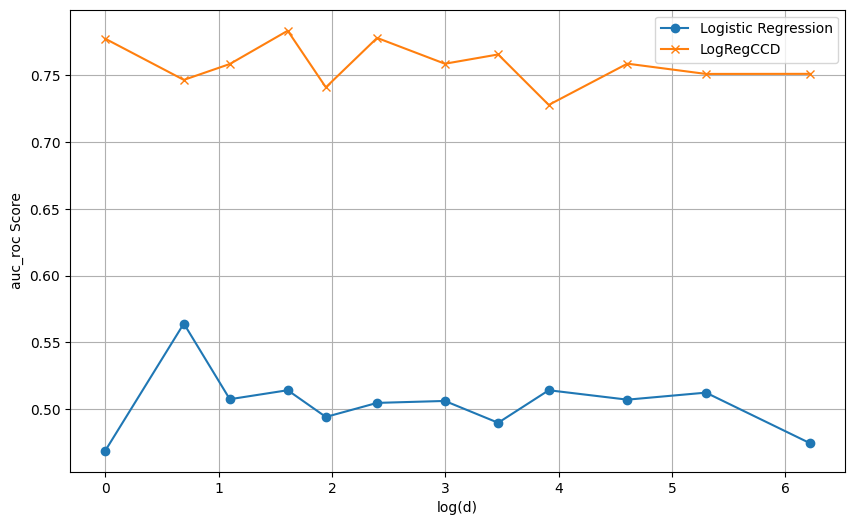

In [ ]:
test_and_plot(metric="auc_roc", test_param="d", param_d=[1,2,3,5,7,11,20,32,50,100,200,500], param_p=[0.5], num_repeats=10)

metric=balanced_accuracy
Running experiment with p=0.1, n=1000, d=1, g=0.5
Running experiment with p=0.1, n=1000, d=3, g=0.5
Running experiment with p=0.1, n=1000, d=7, g=0.5
Running experiment with p=0.1, n=1000, d=12, g=0.5
Running experiment with p=0.1, n=1000, d=18, g=0.5
Running experiment with p=0.1, n=1000, d=24, g=0.5
Running experiment with p=0.1, n=1000, d=30, g=0.5
Running experiment with p=0.1, n=1000, d=35, g=0.5
Running experiment with p=0.1, n=1000, d=40, g=0.5
Running experiment with p=0.1, n=1000, d=50, g=0.5


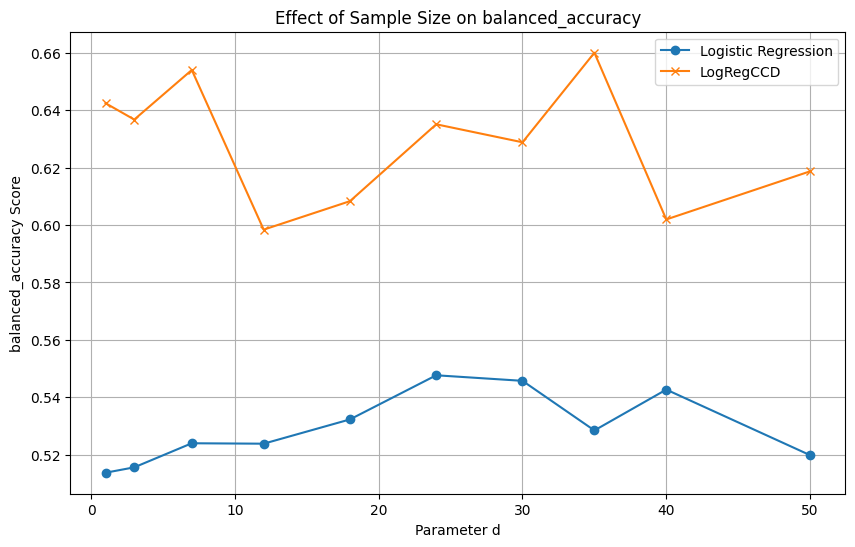

In [152]:
test_and_plot(test_param="d", param_p=[0.1], param_d=[1,3,7,12,18,24,30,35,40,50], num_repeats=10)

metric=balanced_accuracy
Running experiment with p=0.5, n=50, d=100, g=0.5
Running experiment with p=0.5, n=55, d=100, g=0.5


c:\Users\MateuszAndryszak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\MateuszAndryszak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\MateuszAndryszak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\MateuszAndryszak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\MateuszAndryszak\AppData\Local\Programs\Python\Python312\Li

Running experiment with p=0.5, n=63, d=100, g=0.5
Running experiment with p=0.5, n=70, d=100, g=0.5
Running experiment with p=0.5, n=79, d=100, g=0.5
Running experiment with p=0.5, n=89, d=100, g=0.5
Running experiment with p=0.5, n=100, d=100, g=0.5
Running experiment with p=0.5, n=150, d=100, g=0.5
Running experiment with p=0.5, n=200, d=100, g=0.5
Running experiment with p=0.5, n=300, d=100, g=0.5


c:\Users\MateuszAndryszak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Running experiment with p=0.5, n=500, d=100, g=0.5


c:\Users\MateuszAndryszak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\MateuszAndryszak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

Running experiment with p=0.5, n=750, d=100, g=0.5
Running experiment with p=0.5, n=1000, d=100, g=0.5


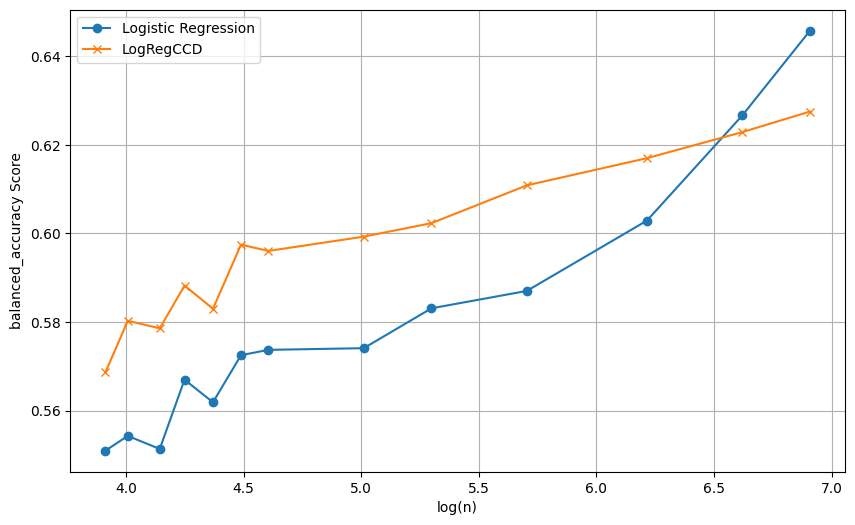

In [234]:
test_and_plot(test_param="n", param_n=[50, 55, 63, 70, 79, 89, 100, 150, 200, 300, 500, 750, 1000], param_p=[0.5], param_d=[100], num_repeats=300)

metric=balanced_accuracy
Running experiment with p=0.5, n=500, d=10, g=0
Running experiment with p=0.5, n=500, d=10, g=0.1
Running experiment with p=0.5, n=500, d=10, g=0.2
Running experiment with p=0.5, n=500, d=10, g=0.3
Running experiment with p=0.5, n=500, d=10, g=0.4
Running experiment with p=0.5, n=500, d=10, g=0.5
Running experiment with p=0.5, n=500, d=10, g=0.6
Running experiment with p=0.5, n=500, d=10, g=0.7
Running experiment with p=0.5, n=500, d=10, g=0.8
Running experiment with p=0.5, n=500, d=10, g=0.9
Running experiment with p=0.5, n=500, d=10, g=1


C:\Users\MateuszAndryszak\AppData\Local\Temp\ipykernel_31936\3977360868.py:14: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(param), scores, label='Logistic Regression', marker='o')
C:\Users\MateuszAndryszak\AppData\Local\Temp\ipykernel_31936\3977360868.py:15: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(param), scores_ccd, label='LogRegCCD', marker='x')


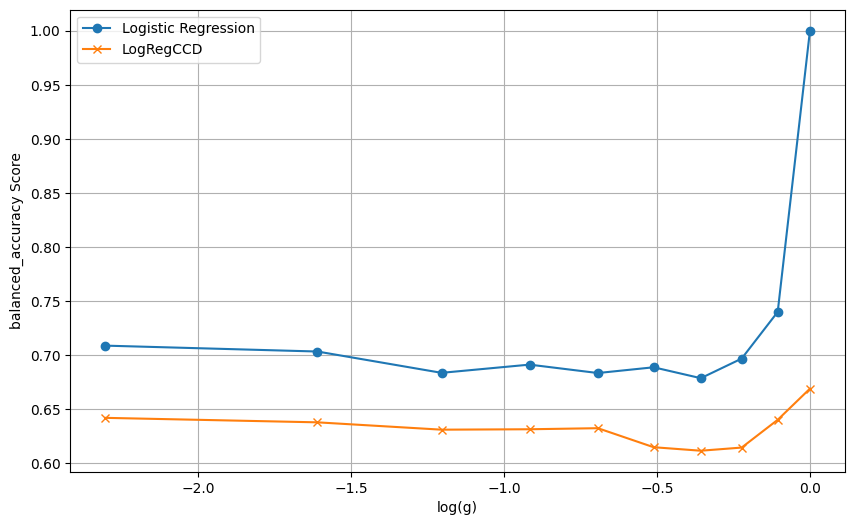

In [213]:
test_and_plot(test_param="g", param_g=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ,1], param_p=[0.5], num_repeats=100)

metric=balanced_accuracy
Running experiment with p=0.1, n=1000, d=50, g=0.5
Running experiment with p=0.2, n=1000, d=50, g=0.5
Running experiment with p=0.3, n=1000, d=50, g=0.5
Running experiment with p=0.4, n=1000, d=50, g=0.5
Running experiment with p=0.5, n=1000, d=50, g=0.5
Running experiment with p=0.6, n=1000, d=50, g=0.5
Running experiment with p=0.7, n=1000, d=50, g=0.5
Running experiment with p=0.8, n=1000, d=50, g=0.5
Running experiment with p=0.9, n=1000, d=50, g=0.5


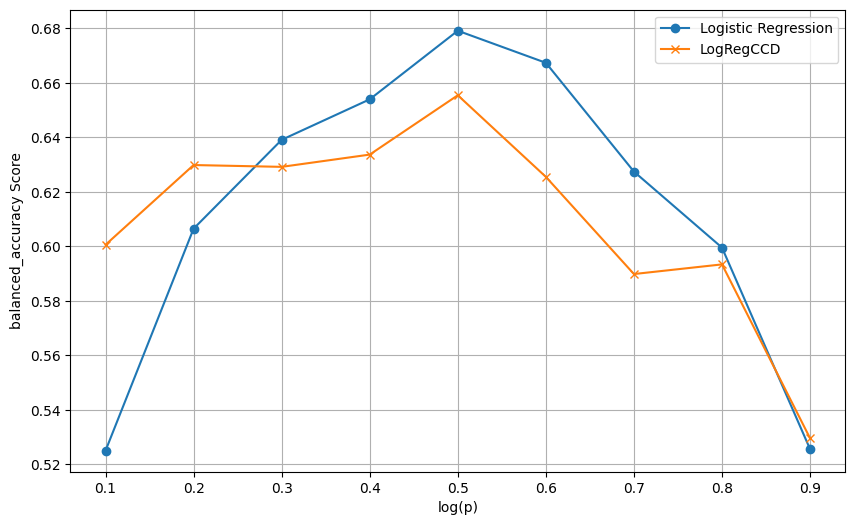

In [232]:
test_and_plot(test_param="p", param_p=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], param_n=[1000], param_d=[50], num_repeats=10)